In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score, classification_report, precision_recall_curve
from scipy.stats import randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load

In [2]:
import warnings 
warnings.filterwarnings('ignore')
SEED = 0
heart_data_orig = pd.read_csv('heart_failure_clinical_records_dataset.csv')
heart_data_prepro = heart_data_orig.copy()

################################################ Inspection of The Dataset ############################################
heart_data_prepro.info()
#No missing values in the data
#all columns are numerical

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [3]:
heart_data_prepro.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


In [4]:
counts = heart_data_prepro['DEATH_EVENT'].value_counts()
print(f"Number of 0s (survived): {counts[0]}")
print(f"Number of 1s (death events): {counts[1]}")

Number of 0s (survived): 203
Number of 1s (death events): 96


In [5]:
X = heart_data_prepro.drop(columns=['DEATH_EVENT'])
y = heart_data_prepro['DEATH_EVENT']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## RF model Without SMOTE

In [7]:
rf_model = RandomForestClassifier(max_depth=300, n_estimators=300, random_state=0)
rf_model.fit(X_train, y_train)
y_pred_no_smote = rf_model.predict(X_test)
print("without SMOTE")
print(classification_report(y_test, y_pred_no_smote))

without SMOTE
              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.80      0.63      0.71        19

    accuracy                           0.83        60
   macro avg       0.82      0.78      0.79        60
weighted avg       0.83      0.83      0.83        60



In [8]:
print("Accuracy:", accuracy_score(y_test, y_pred_no_smote))

Accuracy: 0.8333333333333334


## RF model 10 K-Fold score without SMOTE

In [15]:
from sklearn.model_selection import StratifiedKFold

kfold = StratifiedKFold(n_splits=10, shuffle=True)
scores = cross_val_score(rf_model, X, y, cv=kfold, scoring='accuracy')
scores = []
splits = []
for train_index, test_index in kfold.split(X, y):
    splits.append((train_index, test_index))
    rf_model.fit(X.iloc[train_index], y.iloc[train_index])
    score = rf_model.score(X.iloc[test_index], y.iloc[test_index])
    scores.append(score)

scores = np.array(scores)
best_fold_index = np.argmax(scores)
print("Best fold index:", best_fold_index)
print("Best fold accuracy:", scores[best_fold_index])

Best fold index: 3
Best fold accuracy: 0.9666666666666667


In [16]:
X_train_best = X.iloc[splits[best_fold_index][0]]
y_train_best = y.iloc[splits[best_fold_index][0]]
X_test_best = X.iloc[splits[best_fold_index][1]]
y_test_best = y.iloc[splits[best_fold_index][1]]

rf_model.fit(X_train_best, y_train_best)
best_score = rf_model.score(X_test_best, y_test_best)
print("Accuracy on best fold test set:", best_score)


Accuracy on best fold test set: 0.9666666666666667


In [17]:
y_pred = rf_model.predict(X_test_best)
print(classification_report(y_test_best, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30



## RF model 10 K-Fold score with SMOTE

In [20]:
rf_model = RandomForestClassifier(max_depth=300, n_estimators=300, random_state=0)
smote = SMOTE(random_state=42)

scores = []
splits = []

for train_index, test_index in kfold.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    rf_model.fit(X_train_smote, y_train_smote)
    score = rf_model.score(X_test, y_test)
    scores.append(score)
    splits.append((train_index, test_index))

scores = np.array(scores)
best_fold_index_SMOTE = np.argmax(scores)
print("Best fold index:", best_fold_index_SMOTE)
print("Best fold accuracy:", scores[best_fold_index_SMOTE])

X_train_best = X.iloc[splits[best_fold_index_SMOTE][0]]
y_train_best = y.iloc[splits[best_fold_index_SMOTE][0]]
X_test_best = X.iloc[splits[best_fold_index_SMOTE][1]]
y_test_best = y.iloc[splits[best_fold_index_SMOTE][1]]

X_train_best_smote, y_train_best_smote = smote.fit_resample(X_train_best, y_train_best)

rf_model.fit(X_train_best_smote, y_train_best_smote)
best_score = rf_model.score(X_test_best, y_test_best)
print("Accuracy on best fold test set with SMOTE:", best_score)

Best fold index: 3
Best fold accuracy: 0.9666666666666667
Accuracy on best fold test set with SMOTE: 0.9666666666666667


In [21]:
y_pred = rf_model.predict(X_test_best)
print(classification_report(y_test_best, y_pred))

              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30



## Transfer Learning - RF model

In [22]:
from sklearn.model_selection import cross_val_predict

x_train_copy = pd.DataFrame(X_train_best_smote.copy())
x_test_copy = pd.DataFrame(X_test_best.copy())

train_proba_transfer = cross_val_predict(
    rf_model,
    X_train_best_smote,
    y_train_best_smote,
    cv=5,
    method='predict_proba'
)[:, 1]

test_proba_transfer = rf_model.predict_proba(X_test_best)[:, 1]

transfer_column = ['proba_from_best_model']
prob_features_train = pd.DataFrame(train_proba_transfer, columns=transfer_column)
prob_features_test = pd.DataFrame(test_proba_transfer, columns=transfer_column)

X_train_transfered = pd.concat([x_train_copy.reset_index(drop=True), prob_features_train], axis=1)
X_test_transfered = pd.concat([x_test_copy.reset_index(drop=True), prob_features_test], axis=1)

rf_model_TL = RandomForestClassifier(max_depth=300, n_estimators=300, random_state=0)
rf_model_TL.fit(X_train_transfered, y_train_best_smote)

y_pred = rf_model_TL.predict(X_test_transfered)
accuracy = accuracy_score(y_test_best, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(classification_report(y_test_best, y_pred))


Accuracy: 0.9667
              precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30



                     Feature  Importance
12     proba_from_best_model    0.244730
11                      time    0.232204
7           serum_creatinine    0.108256
4          ejection_fraction    0.094608
2   creatinine_phosphokinase    0.069450
0                        age    0.067909
8               serum_sodium    0.063241
6                  platelets    0.061219
9                        sex    0.014723
1                    anaemia    0.012738
3                   diabetes    0.011627
10                   smoking    0.010839
5        high_blood_pressure    0.008454


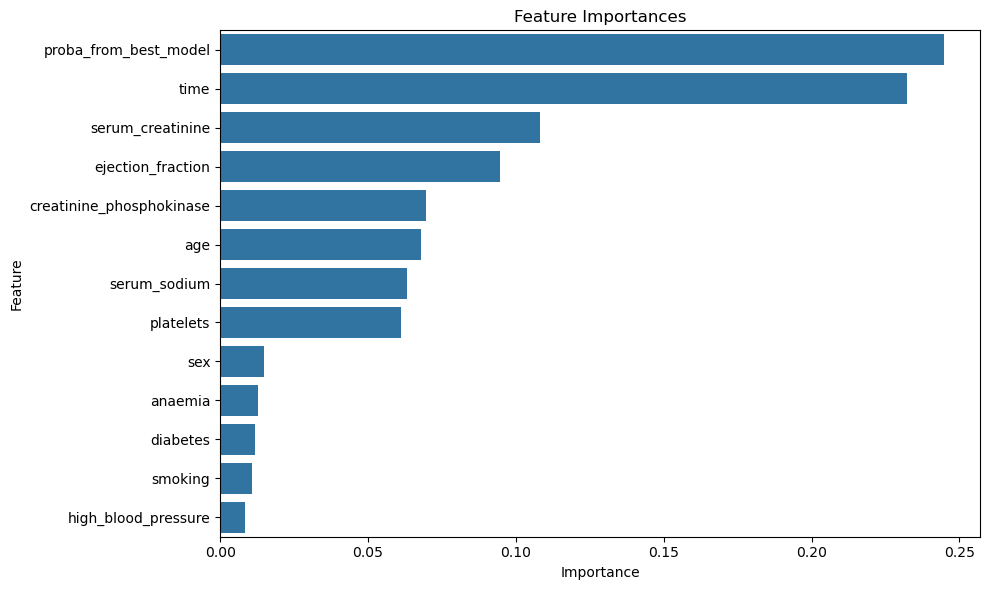

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model_TL.feature_importances_

feature_names = X_train_transfered.columns

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()


## Transfer Learning - XGB Classifier model

In [29]:
from xgboost import XGBClassifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
xgb_model.fit(X_train_transfered, y_train_best_smote)

y_pred = xgb_model.predict(X_test_transfered)

print("Accuracy:", accuracy_score(y_test_best, y_pred))
print("Classification Report:\n", classification_report(y_test_best, y_pred))


Accuracy: 0.9666666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        20
           1       1.00      0.90      0.95        10

    accuracy                           0.97        30
   macro avg       0.98      0.95      0.96        30
weighted avg       0.97      0.97      0.97        30



In [30]:
from sklearn.model_selection import cross_val_predict
rf_proba = cross_val_predict(rf_model,X_train_best_smote , y_train_best_smote, cv=10, method='predict_proba')[:, 1]
X_transfered = X_train_best_smote.copy()
X_transfered["rf_proba"] = rf_proba

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=0)
scores = cross_val_score(xgb_model, X_transfered, y_train_best_smote, cv=10, scoring='accuracy')
print("Accuracy:", scores.mean())

Accuracy: 0.801951951951952


## Transfer Learning - GB model

In [31]:
from sklearn.ensemble import GradientBoostingClassifier

GB_model = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=4, random_state=0)

GB_model.fit(X_train_transfered, y_train_best_smote)
y_pred = GB_model.predict(X_test_transfered)

print("Accuracy:", accuracy_score(y_test_best, y_pred))
print("Classification Report:\n", classification_report(y_test_best, y_pred))

Accuracy: 0.9333333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.90      0.90      0.90        10

    accuracy                           0.93        30
   macro avg       0.93      0.93      0.93        30
weighted avg       0.93      0.93      0.93        30

